In [1]:
%load_ext autoreload
%autoreload 2

# 0. environment setting (from `run.py`)

#### Path Setting
- exectuion path: `/{your_own_env}/kg_txt_multimodal/lxmert`
- src path: `/{your_own_env}/kg_txt_multimodal/lxmert/src`
    - sys.path.append(src_path)

In [2]:
import os
os.getcwd()

In [3]:
os.path.abspath('../..')

'/home/ubuntu/project'

In [4]:
os.chdir('/home/ubuntu/project/kg_txt_multimodal/lxmert')

In [5]:
import sys
sys.path.append('src/')

#### running configuration setting (important)
- you should look `assert` block

In [6]:
# From Huggingface transformers package
from transformers import (
    CONFIG_MAPPING,
    MODEL_WITH_LM_HEAD_MAPPING,
    LxmertConfig,
    LxmertTokenizer,
    PreTrainedTokenizer,
    HfArgumentParser,
    TrainingArguments,
    Trainer,
    set_seed,
)

import numpy as np
import matplotlib.pyplot as plt

import torch

import networkx as nx

In [7]:
# FLAGS
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
TASK_NAME = 'binary_retrieval'
DB = 'dxprx'
MODEL_TYPE = 'kg'
CONFIGURE = 'H128_L2,2,4'
UNIFIED = True

# Variables
Var_TASK = {}
Var_MODEL = {'both':'KGenc_LMinit', 'lm':'LMinit', 'kg':'KGenc', 'rand':'Randinit'}
Var_UNIFIED = 'Unified' if UNIFIED else ''
assert MODEL_TYPE in Var_MODEL, "Model not supported"
assert DB in ['px','dxprx'], "DB not supported"
assert TASK_NAME in ['pretrain','binary_retrieval'], "Task not supported"

# Model Name
## <LMinit & KGenc> : both, <LMinit only> : lm, <KGenc only> : kg, <RandomInit> : rand
## Unified(Placeholder) for Abstract Node : True or False
MODEL_NAME = f'{DB}_{Var_UNIFIED}{"Uni" if MODEL_TYPE in ["both","kg"] else "No"}KGenc'
RUN_NAME = f'{Var_MODEL[MODEL_TYPE]}_{CONFIGURE}_{Var_UNIFIED}{DB}'

# Paths
EXP_PATH = os.getcwd()

In [8]:
# [ dxprx : 960 batches / 32 bsize ]
# [ px : / 32 bsize
TRAINING_CONFIG = {
    "model_type":"lxmert",
    "do_train": True,
    "evaluate_during_training": True,
    "do_eval": True,
    "prediction_loss_only":False,
    "overwrite_output_dir":True,
    "mlm_probability": 0.15,
    "block_size": 512,
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 4,
    "learning_rate": 5e-4,
    "num_train_epochs": 40,
    "logging_steps": int(1920/20),
    "save_steps": int(1e10),
    "eval_steps": int(1920),
    "task" : TASK_NAME,
    "train_data_file": os.path.join(EXP_PATH,"data/{}/train".format(MODEL_NAME)),
    "eval_data_file": os.path.join(EXP_PATH,"data/{}/valid".format(MODEL_NAME)),
    #"test_data_file": os.path.join(EXP_PATH, "data/{}/test".format(MODEL_NAME)),
    "run_name":f"{TASK_NAME}_{RUN_NAME}",
    # for temporal
    "config_name": None,
    "cache_dir": None,
    "tokenizer_name": None,
    "train_data_files": None
}

if TASK_NAME == 'pretrain':
    SRC_PATH = os.path.join(EXP_PATH, 'src/run_pretraining.py')
    TRAINING_CONFIG['config_name'] = os.path.join(EXP_PATH, f"config/config_{Var_UNIFIED}{DB}.json")
    TRAINING_CONFIG['tokenizer_name'] = "bert-base-uncased"
    TRAINING_CONFIG['output_dir'] = os.path.join(EXP_PATH,"pretrained_models/{}".format(RUN_NAME))
else:
    SRC_PATH = os.path.join(EXP_PATH, 'src/run_downstream.py')
    TRAINING_CONFIG['model_name_or_path'] = os.path.join(EXP_PATH, f'pretrained_models/{RUN_NAME}')
    TRAINING_CONFIG['output_dir'] = os.path.join(EXP_PATH,f"pretrained_models/{TASK_NAME}_{RUN_NAME}")

In [9]:
import easydict 

args = easydict.EasyDict(TRAINING_CONFIG)

train_args = TrainingArguments(output_dir='test',
                               do_train=True,
                               do_eval=False,
                               local_rank=-1,
                               per_device_train_batch_size=4,    
                               learning_rate=1e-3,
                               num_train_epochs=1,
                              seed=1234)

set_seed(train_args.seed)

In [10]:
import easydict 

args = easydict.EasyDict(TRAINING_CONFIG)

train_args = TrainingArguments(output_dir='test',
                               do_train=True,
                               do_eval=False,
                               local_rank=-1,
                               per_device_train_batch_size=32,    
                               learning_rate=1e-3,
                               num_train_epochs=1,
                              seed=1234)

# set_seed(train_args.seed)

In [11]:
if Var_UNIFIED in MODEL_NAME:
    KG_LABEL_PATH = os.path.join(EXP_PATH, f"data/{MODEL_NAME}/node2uninode")
else:
    KG_LABEL_PATH = os.path.join(EXP_PATH, f"data/{MODEL_NAME}/id2label")

# 1. Load config/tokenizer/model

#### Load configuration

In [12]:
if args.config_name:
    config = LxmertConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
elif args.model_name_or_path:
    config = LxmertConfig.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
else:
    config = CONFIG_MAPPING[args.model_type]()
    logger.warning("You are instantiating a new config instance from scratch.")

#### Load tokenizer

In [13]:
if args.tokenizer_name:
    tokenizer = LxmertTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
elif args.model_name_or_path:
    tokenizer = LxmertTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
else:
    raise ValueError(
        "You are instantiating a new tokenizer from scratch. This is not supported, but you can do it from another script, save it,"
        "and load it from here, using --tokenizer_name"
    )
if ((config.num_attention_heads % config.num_relations) != 0) and config.gcn and ('Multi' in args.output_dir):
    raise ValueError(
        "# attentions heads must be divisible by # relations"
    )

#### Load model

In [14]:
from model import LxmertForRanking

if args.model_name_or_path:
    model = LxmertForRanking.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=args.cache_dir,
    )
else:
    logger.info("Training new model from scratch")
    model = LxmertForRanking(config)

Some weights of the model checkpoint at /home/ubuntu/project/kg_txt_multimodal/lxmert/pretrained_models/KGenc_H128_L2,2,4_Unifieddxprx were not used when initializing LxmertForRanking: ['classifier.weight', 'classifier.bias', 'lm_head.predictions.bias', 'lm_head.predictions.transform.dense.weight', 'lm_head.predictions.transform.dense.bias', 'lm_head.predictions.transform.LayerNorm.weight', 'lm_head.predictions.transform.LayerNorm.bias', 'lm_head.predictions.decoder.weight', 'lm_head.seq_relationship.weight', 'lm_head.seq_relationship.bias', 'lxmert.pooler.dense.weight', 'lxmert.pooler.dense.bias']
- This IS expected if you are initializing LxmertForRanking from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LxmertForRanking from the checkpoint of a model that you expect to be exactly identical (initializing a BertForS

## 2. Load datasets

In [15]:
from utils.dataset import get_dataset

# Get datasets
train_dataset = (
    get_dataset(args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"]) if args.do_train else None
)
eval_dataset = (
    get_dataset(args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"], evaluate=True)
    if args.do_eval
    else None
)

### check dataset

In [16]:
args.train_data_file

'/home/ubuntu/project/kg_txt_multimodal/lxmert/data/dxprx_UnifiedUniKGenc/train'

In [17]:
len(train_dataset)

30061

In [18]:
idx = 30000
# by vars, InputFeatures class to dict class
sample = vars(train_dataset.features[idx])

In [19]:
sample.keys()

dict_keys(['lang_input_ids', 'kg_input_ids', 'lang_attention_mask', 'kg_attention_mask', 'kg_label_mask', 'kg_label', 'token_type_ids'])

#### check dataset - text side

mean(length): 47.3299956754599
std(length): 43.9053928911847
max(length): 511
min(length): 3


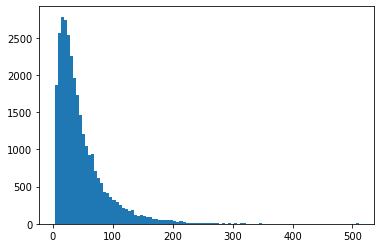

In [20]:
# check train_dataset information in text part
total_len = []
pad_token_id = tokenizer.pad_token_id

for idx in range(len(train_dataset)):
    cur_len = len([i for i in train_dataset.features[idx].lang_input_ids if i != pad_token_id])
    cur_len -= 1 # exclude [CLS]
    total_len.append(cur_len)
        
_ = plt.hist(total_len, bins=100)
print('mean(length):', np.average(total_len))
print('std(length):', np.std(total_len))
print('max(length):', np.max(total_len))
print('min(length):', np.min(total_len))

In [21]:
print('all tokens w/ padding tokens (text part):', len(sample['lang_input_ids']))
print('all tokens wo/ padding tokens (text part):', len([i for i in sample['lang_input_ids'] if i != pad_token_id]) )

print('all 1\'s in attention mask (text part):', len([i for i in sample['lang_attention_mask'] if i != 0]))

all tokens w/ padding tokens (text part): 512
all tokens wo/ padding tokens (text part): 73
all 1's in attention mask (text part): 73


In [22]:
tokenizer.decode(sample['lang_input_ids'], skip_special_tokens=True)

's / p cabgx4 af tachy - brady syndrome past pci hypercholesterolemia htn mild ar h / o lymphoma h / o diverticulitis - cabgx4 ( lima - lad, svg - > diag, svg - > om1, svg - > om2 )'

#### check dataset - graph side

mean(branch): 17.381269197077057
std(branch): 8.915094855179118
max(branch): 77.0
min(branch): 1.0


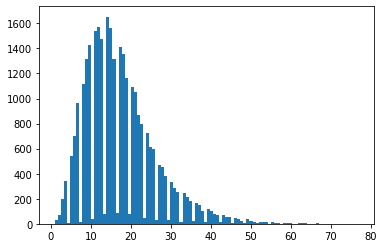

In [23]:
# check train_dataset information in text part
total_len = []
pad_token_id = config.kg_special_token_ids['PAD']

for idx in range(len(train_dataset)):
    cur_len = len([i for i in train_dataset.features[idx].kg_input_ids if i != pad_token_id])
    cur_len -= 2 # exclude [CLS], [HADM]
    cur_len /= 3 # each branch has 3 nodes (ex. px - px_icd - literal)
    total_len.append(cur_len)
    
# including abstract node    
_ = plt.hist(total_len, bins=100)
print('mean(branch):', np.average(total_len))
print('std(branch):', np.std(total_len))
print('max(branch):', np.max(total_len))
print('min(branch):', np.min(total_len))

In [24]:
# get label in kg part
node2id = torch.load(KG_LABEL_PATH)
id2node = {v:k for k, v in node2id.items()}
assert len(id2node.keys()) == config.vocab_size['kg']

In [25]:
print('all tokens w/ padding tokens (graph part):', len(sample['kg_input_ids']))
sample_kg_input_len = len([i for i in sample['kg_input_ids'] if i != config.kg_special_token_ids['PAD']]) 
print('all tokens wo/ padding tokens (graph part):', sample_kg_input_len)

all tokens w/ padding tokens (graph part): 240
all tokens wo/ padding tokens (graph part): 47


In [26]:
sample_A = sample['kg_attention_mask'].numpy()[:sample_kg_input_len, :sample_kg_input_len]

In [27]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, k=2/(G.order()**0.5))
    nx.draw(G, pos, node_size=800, labels=mylabels, with_labels=True)
    plt.show()

In [28]:
sample_id2node = {i:id2node[k].split('^^')[0] for i, k in enumerate(sample['kg_input_ids']) if k != config.kg_special_token_ids['PAD']}

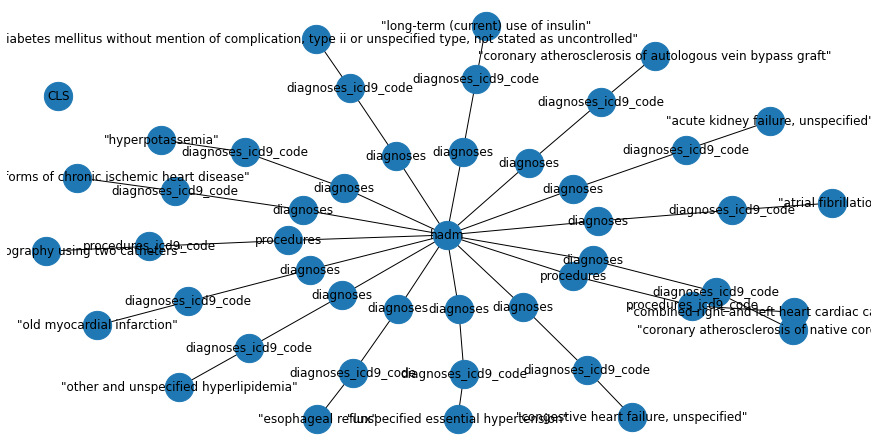

In [29]:
plt.figure(figsize=(12,6))
show_graph_with_labels(sample_A, sample_id2node)

#### <span style="color:#b8b4b4"> check dataset in pairwise </span>

In [30]:
idx = 30000
sample = vars(train_dataset.features[idx])
print('**********text**********')
print(tokenizer.decode(sample['lang_input_ids'], skip_special_tokens=True))
print()
print()
sample_id2node = {i:id2node[k].split('^^')[0] for i, k in enumerate(sample['kg_input_ids']) if k != config.kg_special_token_ids['PAD']}
print('**********graph**********')
print(sample_id2node)

**********text**********
s / p cabgx4 af tachy - brady syndrome past pci hypercholesterolemia htn mild ar h / o lymphoma h / o diverticulitis - cabgx4 ( lima - lad, svg - > diag, svg - > om1, svg - > om2 )


**********graph**********
{0: 'CLS', 1: 'hadm', 2: 'diagnoses', 3: 'diagnoses', 4: 'diagnoses', 5: 'diagnoses', 6: 'diagnoses', 7: 'diagnoses', 8: 'diagnoses', 9: 'procedures', 10: 'diagnoses', 11: 'procedures', 12: 'diagnoses', 13: 'diagnoses', 14: 'diagnoses', 15: 'diagnoses', 16: 'diagnoses', 17: 'diagnoses_icd9_code', 18: 'diagnoses_icd9_code', 19: 'diagnoses_icd9_code', 20: 'diagnoses_icd9_code', 21: 'diagnoses_icd9_code', 22: 'diagnoses_icd9_code', 23: 'diagnoses_icd9_code', 24: 'procedures_icd9_code', 25: 'diagnoses_icd9_code', 26: 'procedures_icd9_code', 27: 'diagnoses_icd9_code', 28: 'diagnoses_icd9_code', 29: 'diagnoses_icd9_code', 30: 'diagnoses_icd9_code', 31: 'diagnoses_icd9_code', 32: '"congestive heart failure, unspecified"', 33: '"long-term (current) use of insulin"

# 3. Load collator

- binary_retrieval
    - label: 1(matched), 0(not-matched)
    - kg_attention_mask: structure_aware mask
    - kg_padding_mask: padding mask

In [31]:
from utils.data_collator import NegativeSampling_DataCollator

if args.task == 'binary_retrieval':
    data_collator = NegativeSampling_DataCollator(tokenizer=tokenizer,
                                                  kg_special_token_ids=config.kg_special_token_ids,
                                                  NCE=False,
                                                  n_negatives=1)

### check data collator

In [32]:
bsz = 3
samples_batch = data_collator(train_dataset[:bsz])

In [33]:
samples_batch.keys()

dict_keys(['lang_input_ids', 'kg_input_ids', 'kg_padding_mask', 'lang_attention_mask', 'kg_attention_mask', 'token_type_ids', 'label'])

#### <span style="color:#b8b4b4"> check compatibility between datacollator and dataset </span>

In [34]:
# bsz = args.per_device_train_batch_size
bsz = 3
samples_batch = data_collator(train_dataset[:bsz])
sample = train_dataset.features[:bsz]

In [35]:
# dataset size: bsz

for idx in range(bsz):
    decoded_text = tokenizer.decode(sample[idx].lang_input_ids, skip_special_tokens=True)
    decoded_kg = [id2node[i].split('^^')[0] for i in sample[idx].kg_input_ids if i != config.kg_special_token_ids['PAD']]
    
    print(idx, '\n')
    print(decoded_text)
    print()
    print(decoded_kg)
    print('\n\n')

0 

1. cervical spondylosis with calcification of posterior longitudinal ligament. 2. fracture dislocation c6 - c7. 3. ossification of the posterior longitudinal ligament. 4. aspiration pneumonia 1. cervical spondylosis with calcification of posterior longitudinal ligament. 2. fracture dislocation c6 - c7. 3. ossification of the posterior longitudinal ligament. 4. aspiration pneumonia 1. cervical spondylosis with calcification of posterior longitudinal ligament. 2. fracture dislocation c6 - c7. 3. ossification of the posterior longitudinal ligament. 4. aspiration pneumonia1. anterior cervical osteotomy, c6 - c7, with decompression and excision of ossification of the posterior longitudinal ligament. 2. anterior cervical deformity correction. 3. interbody reconstruction. 4. anterior cervical fusion, c5 - c6 - c7. 5. plate instrumentation, c5 - c6 - c7. 6. cervical laminectomy c6 - c7, t1. 7. posterior cervical arthrodesis c4 - t1. 8. cervical instrumentation c4 - t1. 9. arthrodesis augme

In [36]:
# data collator size: 2*bsz

for idx in range(bsz*2):
    decoded_text = tokenizer.decode(samples_batch['lang_input_ids'][idx], skip_special_tokens=True)
    decoded_kg = [id2node[i.item()].split('^^')[0] for i in samples_batch['kg_input_ids'][idx] if i != config.kg_special_token_ids['PAD']]
    label = int(samples_batch['label'][idx])
    
    print(f'idx:{idx} --- label:{label} \n')
    print(decoded_text)
    print()
    print(decoded_kg)
    print('\n\n')

idx:0 --- label:1 

1. cervical spondylosis with calcification of posterior longitudinal ligament. 2. fracture dislocation c6 - c7. 3. ossification of the posterior longitudinal ligament. 4. aspiration pneumonia 1. cervical spondylosis with calcification of posterior longitudinal ligament. 2. fracture dislocation c6 - c7. 3. ossification of the posterior longitudinal ligament. 4. aspiration pneumonia 1. cervical spondylosis with calcification of posterior longitudinal ligament. 2. fracture dislocation c6 - c7. 3. ossification of the posterior longitudinal ligament. 4. aspiration pneumonia1. anterior cervical osteotomy, c6 - c7, with decompression and excision of ossification of the posterior longitudinal ligament. 2. anterior cervical deformity correction. 3. interbody reconstruction. 4. anterior cervical fusion, c5 - c6 - c7. 5. plate instrumentation, c5 - c6 - c7. 6. cervical laminectomy c6 - c7, t1. 7. posterior cervical arthrodesis c4 - t1. 8. cervical instrumentation c4 - t1. 9. a

# 4. Define Trainer

In [37]:
trainer = Trainer(
        model=model,
        args=train_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

# 5. Trainer-Training

In [38]:
# Training
if train_args.do_train:
    model_path = (
        args.model_name_or_path
        if args.model_name_or_path is not None and os.path.isdir(args.model_name_or_path)
        else None
    )
    trainer.train(model_path=model_path)
    trainer.save_model()
    # For convenience, we also re-save the tokenizer to the same directory,
    # so that you can share your model easily on huggingface.co/models =)
    if trainer.is_world_master():
        tokenizer.save_pretrained(args.output_dir)

test


wandb: Currently logged in as: biopre (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss
500,0.693347


/home/ubuntu/anaconda3/envs/kg_text/lib/python3.7/site-packages/transformers/trainer.py:1174: FutureWarning: This method is deprecated, use `Trainer.is_world_process_zero()` instead.
  warnings.warn("This method is deprecated, use `Trainer.is_world_process_zero()` instead.", FutureWarning)
